# Industry-Standard SVM Pipeline for HFT

This notebook implements a complete End-to-End Machine Learning pipeline for High-Frequency Trading (HFT) prediction using Support Vector Machines (SVM).

## Pipeline Stages
1.  **Data Loading & Cleaning**: Handle missing values and outliers.
2.  **Ternary-to-Binary Conversion**: Map FI-2010 labels to Binary (Up vs Not Up).
3.  **Exploratory Data Analysis (EDA)**: Understand feature distributions and correlations.
4.  **Feature Engineering**: Create domain-specific features (Spreads, Imbalances, Mid-Prices).
5.  **Feature Selection**: Identify the most predictive features using RFE (Recursive Feature Elimination).
6.  **Model Training**: Train Linear and Kernel SVMs with rigorous Hyperparameter Tuning.
7.  **Evaluation**: Professional performance metrics (Precision, Recall, F1, ROC-AUC) and Latency analysis.
8.  **Parameter Export**: Save model parameters (Weights vs Support Vectors) for FPGA Deployment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
)
from sklearn.pipeline import Pipeline
import time
import json

# Set gathered random seed for reproducibility
np.random.seed(42)
sns.set_style("whitegrid")

## 1. Data Loading & Cleaning & Binary Conversion

In [2]:
# Load Data.csv (which has headers)
try:
    df = pd.read_csv('Data.csv')
    print(f"Dataset loaded successfully. Shape: {df.shape}")
    
    # Standardize column names
    df.columns = df.columns.str.strip()
    print(f"Columns ({len(df.columns)}): {df.columns.tolist()[:5]}...")
    
except Exception as e:
    print(f"Error loading data: {e}")

# Data Cleaning
print("\n--- Data Cleaning ---")
print(f"Initial shape: {df.shape}")
print(f"Missing values per column:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

# Drop rows with ANY missing values
df_clean = df.dropna()
print(f"After dropping NaN: {df_clean.shape}")

# Check for infinite values
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
inf_mask = np.isinf(df_clean[numeric_cols]).any(axis=1)
if inf_mask.sum() > 0:
    print(f"Dropping {inf_mask.sum()} rows with infinite values")
    df_clean = df_clean[~inf_mask]

print(f"Final clean shape: {df_clean.shape}")
df = df_clean

# --- TERNARY TO BINARY CONVERSION ---
# Assume target is the last column
target_col = df.columns[-1]
y_raw = df[target_col]
print(f"\nRaw Target Values: {y_raw.unique()}")
print(f"Raw Distribution:\n{y_raw.value_counts(normalize=True)}")

# Strategy: 1 = UP, 0 = (Stationary OR Down)
# Typically: Up=1, Stationary=2 (or 0), Down=3 (or -1)
# We force: Value '1' -> 1, All others -> 0
df['target_binary'] = np.where(y_raw == 1, 1, 0)

print(f"Binary Target Distribution (1=Up, 0=Other):\n{df['target_binary'].value_counts(normalize=True)}")

# Use new binary target
df = df.drop(columns=[target_col]) # Drop raw
target_col = 'target_binary' # Update target name

display(df.head())

Dataset loaded successfully. Shape: (272941, 48)
Columns (48): ['Unnamed: 0', 'STOCK', 'DAY', 'PRICE_ASK_0', 'PRICE_ASK_1']...

--- Data Cleaning ---
Initial shape: (272941, 48)
Missing values per column:
Series([], dtype: int64)
After dropping NaN: (272941, 48)
Final clean shape: (272941, 48)

Raw Target Values: [ 0  1 -1]
Raw Distribution:
LABEL_10TICK
 1    0.395946
-1    0.387021
 0    0.217032
Name: proportion, dtype: float64
Binary Target Distribution (1=Up, 0=Other):
target_binary
0    0.604054
1    0.395946
Name: proportion, dtype: float64


,Unnamed: 0,STOCK,DAY,PRICE_ASK_0,PRICE_ASK_1,PRICE_ASK_2,PRICE_ASK_3,PRICE_ASK_4,PRICE_ASK_5,PRICE_ASK_6,...,VOLUME_BID_5,VOLUME_BID_6,VOLUME_BID_7,VOLUME_BID_8,VOLUME_BID_9,LABEL_1TICK,LABEL_2TICK,LABEL_3TICK,LABEL_5TICK,target_binary
0,0,1,1,2615,2618,2619,2620,2621,2623,2625,...,100,143,134,123,128,0,0,0,0,0
1,1,1,1,2615,2619,2620,2621,2625,2626,2629,...,159,100,143,134,123,0,0,0,0,0
2,2,1,1,2614,2615,2617,2619,2620,2621,2625,...,159,100,143,134,123,-1,-1,0,0,0
3,3,1,1,2614,2617,2619,2620,2621,2625,2629,...,100,143,134,123,128,0,0,-1,0,0
4,4,1,1,2614,2617,2619,2620,2621,2625,2629,...,100,143,134,123,128,1,1,1,0,0


## 2. Exploratory Data Analysis (EDA)

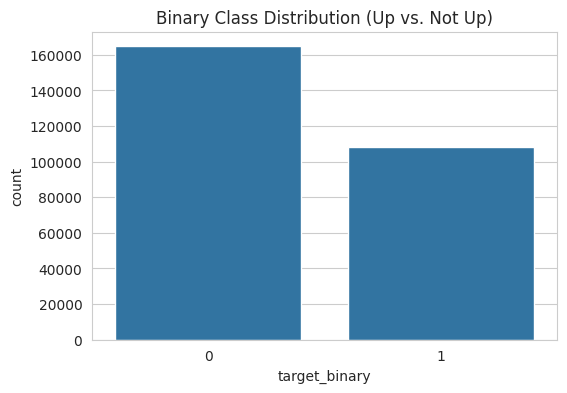

target_binary
0    0.604054
1    0.395946
Name: proportion, dtype: float64


In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title("Binary Class Distribution (Up vs. Not Up)")
plt.show()

print(df[target_col].value_counts(normalize=True))

## 3. Feature Engineering
For now, we'll use the raw features. Domain-specific features can be added if column names are known.

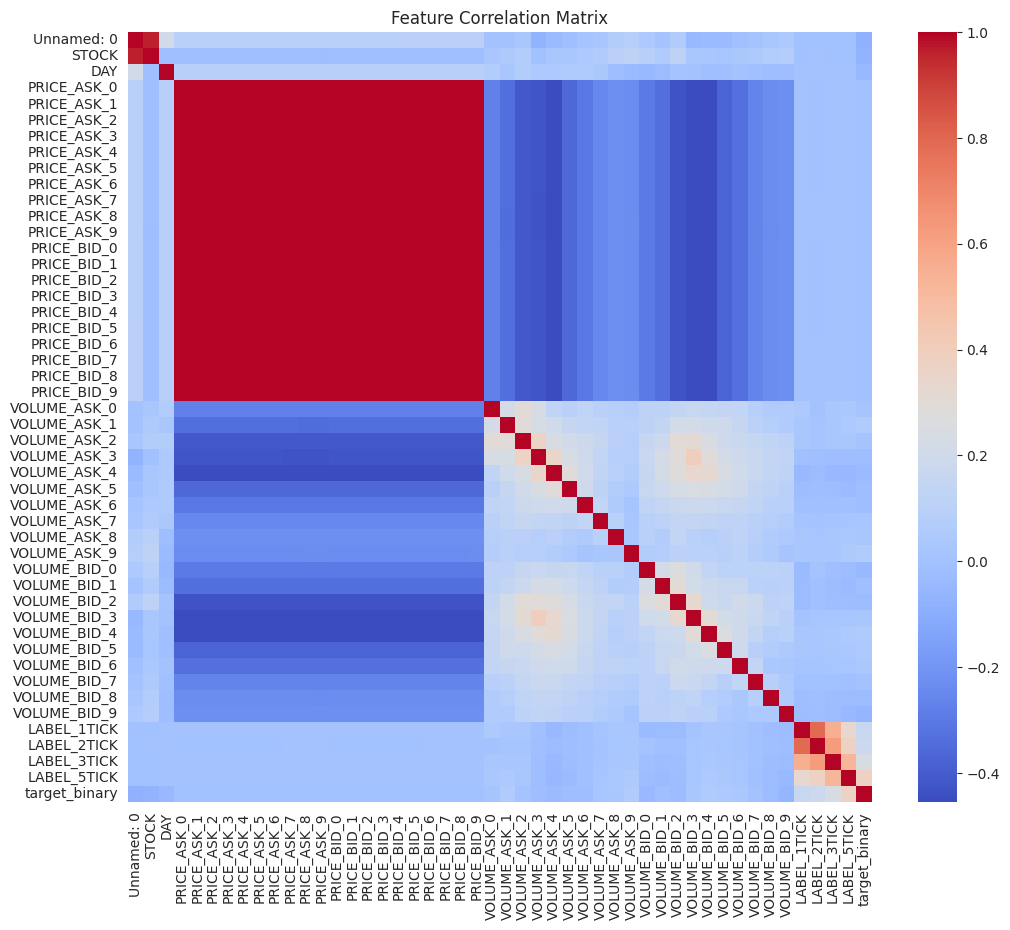

In [4]:
df_eng = df.copy()

# Feature Correlations (sample if too large)
if len(df_eng.columns) > 50:
    print("Too many columns for full heatmap, showing correlation with target only")
    # Filter only numeric columns before correlation
    numeric_df = df_eng.select_dtypes(include=[np.number])
    corr_with_target = numeric_df.corr()[target_col].sort_values(ascending=False)
    print(corr_with_target.head(20))
else:
    corr_matrix = df_eng.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
    plt.title("Feature Correlation Matrix")
    plt.show()

## 4. Feature Selection (RFE)
Selecting the top 20 most important features using RFE.

In [5]:
X = df_eng.drop(columns=[target_col])
y = df_eng[target_col]

print(f"Features: {X.shape[1]}, Samples: {len(X)}")

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale Data (RobustScaler)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Running Recursive Feature Elimination (RFE)...")
estimator = LinearSVC(C=0.1, dual=False, max_iter=5000)
# Select Top 20 Features (or fewer if total features < 20)
n_features = min(20, X.shape[1])
selector = RFE(estimator, n_features_to_select=n_features, step=2)
selector = selector.fit(X_train_scaled, y_train)

selected_features = X.columns[selector.support_]
print(f"Selected {len(selected_features)} Features: {list(selected_features)}")

X_train_sel = selector.transform(X_train_scaled)
X_test_sel = selector.transform(X_test_scaled)

Features: 47, Samples: 272941
Running Recursive Feature Elimination (RFE)...
Selected 20 Features: ['PRICE_ASK_0', 'PRICE_ASK_1', 'PRICE_ASK_2', 'PRICE_ASK_3', 'PRICE_ASK_4', 'PRICE_ASK_5', 'PRICE_ASK_7', 'PRICE_ASK_8', 'PRICE_ASK_9', 'PRICE_BID_0', 'PRICE_BID_1', 'PRICE_BID_2', 'PRICE_BID_3', 'PRICE_BID_4', 'PRICE_BID_5', 'PRICE_BID_6', 'PRICE_BID_7', 'PRICE_BID_8', 'PRICE_BID_9', 'LABEL_5TICK']


## 5. Model Training & Tuning

In [6]:
# A. Linear SVM Tuning
param_grid_lin = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_lin = GridSearchCV(LinearSVC(dual=False, max_iter=5000), param_grid_lin, cv=5, scoring='f1_weighted', n_jobs=-1)

print("Training Linear SVM...")
start = time.time()
grid_lin.fit(X_train_sel, y_train)
lin_time = time.time() - start

best_lin_model = grid_lin.best_estimator_
print(f"Best Linear Params: {grid_lin.best_params_}")
print(f"Training Time: {lin_time:.2f}s")

# B. Kernel SVM (RBF) Tuning
param_dist_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1]
}
sub_size = min(len(X_train_sel), 20000)
print(f"\nTraining Kernel SVM (Subsampled to {sub_size})...")

search_rbf = RandomizedSearchCV(SVC(kernel='rbf'), param_dist_rbf, n_iter=10, cv=3, scoring='f1_weighted', n_jobs=-1, random_state=42)
start = time.time()
search_rbf.fit(X_train_sel[:sub_size], y_train[:sub_size])
rbf_time = time.time() - start

best_rbf_model = search_rbf.best_estimator_
print(f"Best Kernel Params: {search_rbf.best_params_}")
print(f"Training Time: {rbf_time:.2f}s")

Training Linear SVM...
Best Linear Params: {'C': 0.001}
Training Time: 8.89s

Training Kernel SVM (Subsampled to 20000)...
Best Kernel Params: {'gamma': 0.1, 'C': 100}
Training Time: 186.59s


## 6. Professional Evaluation


==================== Linear SVM EVALUATION ====================
Accuracy: 0.7452
F1 Score: 0.7402
Latency:  0.84 µs/sample

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80     32975
           1       0.71      0.60      0.65     21614

    accuracy                           0.75     54589
   macro avg       0.74      0.72      0.72     54589
weighted avg       0.74      0.75      0.74     54589



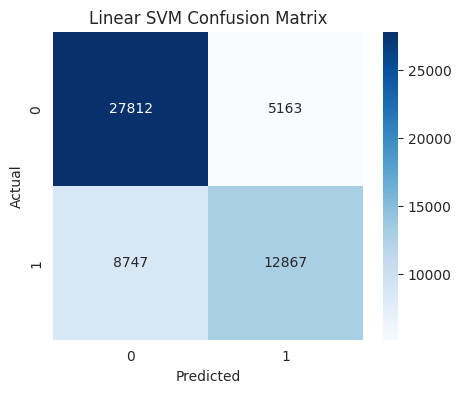


==================== Kernel SVM EVALUATION ====================
Accuracy: 0.7452
F1 Score: 0.7402
Latency:  583.39 µs/sample

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80     32975
           1       0.71      0.60      0.65     21614

    accuracy                           0.75     54589
   macro avg       0.74      0.72      0.72     54589
weighted avg       0.74      0.75      0.74     54589



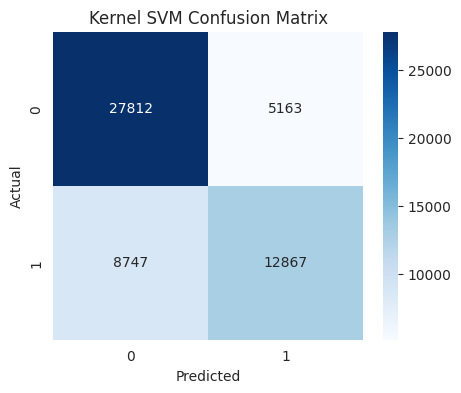

In [7]:
def evaluate_professional(model, X_test, y_test, model_name):
    print(f"\n{'='*20} {model_name} EVALUATION {'='*20}")
    start = time.time()
    y_pred = model.predict(X_test)
    lat = (time.time() - start) / len(X_test) * 1e6 # microseconds
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Latency:  {lat:.2f} µs/sample")
    
    # Detailed Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return acc, f1, lat

res_lin = evaluate_professional(best_lin_model, X_test_sel, y_test, "Linear SVM")
res_rbf = evaluate_professional(best_rbf_model, X_test_sel, y_test, "Kernel SVM")

## 7. Export Model Parameters (JSON & Quantized Data)

**FIXED POINT CONVERSION (Q8.8)**
To deploy on FPGA, we must quantize floating point values to fixed point integers.
- Scaling Factor: 256 (2^8)
- Format: 16-bit Signed Integer (1 sign, 7 int, 8 frac)
- Formula: `int(value * 256)`

In [9]:
SCALE_FACTOR = 256.0

# 1. Linear SVM Parameters (Quantized)
weights_q = [int(w * SCALE_FACTOR) for w in best_lin_model.coef_[0]]
bias_q = int(best_lin_model.intercept_[0] * SCALE_FACTOR)

linear_params = {
    "type": "linear",
    "weights": weights_q,
    "bias": bias_q,
    "n_features": len(weights_q),
    "selected_features": list(selected_features),
    "accuracy": float(res_lin[0]),
    "f1_score": float(res_lin[1]),
    "scale_factor": 256
}

with open('results/linear_params.json', 'w') as f:
    json.dump(linear_params, f, indent=4)
    
print("Saved QUANTIZED Linear SVM parameters to 'results/linear_params.json'")

# 2. Kernel SVM Parameters (Quantized)
gamma_q = int(best_rbf_model._gamma * SCALE_FACTOR)
bias_rbf_q = int(best_rbf_model.intercept_[0] * SCALE_FACTOR)
dual_coef_q = [[int(x * SCALE_FACTOR) for x in row] for row in best_rbf_model.dual_coef_]
sv_q = [[int(x * SCALE_FACTOR) for x in row] for row in best_rbf_model.support_vectors_]

kernel_params = {
    "type": "rbf",
    "gamma": gamma_q,
    "bias": bias_rbf_q,
    "n_support": int(len(best_rbf_model.support_)),
    "dual_coef": dual_coef_q,
    "support_vectors": sv_q,
    "selected_features": list(selected_features),
    "accuracy": float(res_rbf[0]),
    "f1_score": float(res_rbf[1]),
    "scale_factor": 256
}

with open('results/kernel_params.json', 'w') as f:
    json.dump(kernel_params, f)

print(f"Saved QUANTIZED Kernel SVM parameters to 'results/kernel_params.json'")

# 3. Export Quantized Test Data (First 1000 samples for FPGA/Sim)
test_data = {
    "X_test": [[int(x * SCALE_FACTOR) for x in row] for row in X_test_sel[:1000]],
    "y_test": [int(y) for y in y_test[:1000]],
    "n_samples": 1000,
    "n_features": len(selected_features)
}
with open('results/test_data.json', 'w') as f:
    json.dump(test_data, f)
print("Saved QUANTIZED Test Data (first 1000 samples) to 'results/test_data.json'")

Saved QUANTIZED Linear SVM parameters to 'results/linear_params.json'
Saved QUANTIZED Kernel SVM parameters to 'results/kernel_params.json'
Saved QUANTIZED Test Data (first 1000 samples) to 'results/test_data.json'
